# Transformer

At the present moment, the dominant models for nearly all natural language processing tasks are based on the Transformer architecture. Given any new task in natural language processing, the default first-pass approach is to grab a large Transformer-based pretrained model, adapting the output layers as necessary, and fine-tuning the model on the available data for the downstream task. 

## Queries, Keys and Values

In [57]:
import torch
import pandas as pd
from torch import nn
from d2l import torch as d2l
import math

We define the **show_heatmaps** function. The input matrices has the shape (number of rows for display, number of columns for display, number of queries, number of keys). 

In [58]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

As a quick sanity check let’s visualize the identity matrix, representing a case where the attention weight is only when the query and the key are the same.

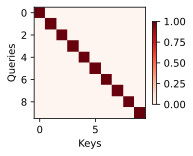

In [59]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## Nadaraya–Watson Regression

At their core, Nadaraya–Watson estimators rely on some similarity kernel $\alpha(q, k)$ relating queries $q$ to keys $k$. There are many more choices that we could pick as the kernel. For example, the Gaussian kernel:
$$\alpha(q, k) = \text{exp}\left(-\frac{1}{2}\|q-k\|^2\right)$$
Regardless, all of them lead to the following equation for regression and classification alike:

$$f(q) = \sum_i \frac{\alpha(q, k_i)}{\sum_j \alpha(q, k_j)}v_i$$

To see Nadaraya–Watson estimation in action, let’s define some training data. In the following we use the dependency
$$y_i = 2\sin(x_i) + x_i + \epsilon$$
where $\epsilon$ is drawn from a normal distribution with zero mean and unit variance. We draw 40 training examples.

In [60]:
def f(x):
    return 2 * torch.sin(x) + x

n_train = 40
x_train, _ = torch.sort(torch.rand(n_train) * 5) # Sorts the tensor in ascending order
# Returns sorted tensor and the original indices
y_train = f(x_train) + torch.randn(n_train)
x_val = torch.arange(0, 5, 0.1) # Generates a 1D tensor with values from start to end with steps
y_val = f(x_val)

Different kernels correspond to different notions of range and smoothness.

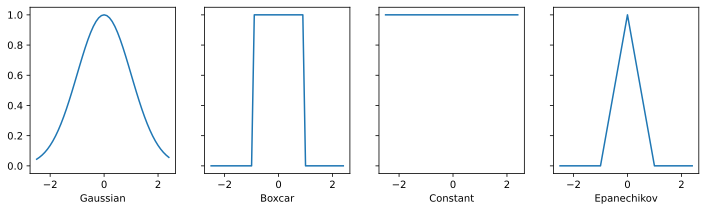

In [61]:
# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

Now that we have data and kernels, all we need is a function that computes the kernel regression estimates. Let each validation feature be a query, and each training feature–label pair be a key–value pair. As a result, the normalized relative kernel weights (attention_w below) are the attention weights.

In [62]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1)) # pairwise difference
    k = kernel(dists).type(torch.float32)
    attention_w = k / k.sum(0) # normalization, (n_train, n_val)
    y_hat = y_train@attention_w
    return y_hat, attention_w

Let’s have a look at the kind of estimates that the different kernels produce.

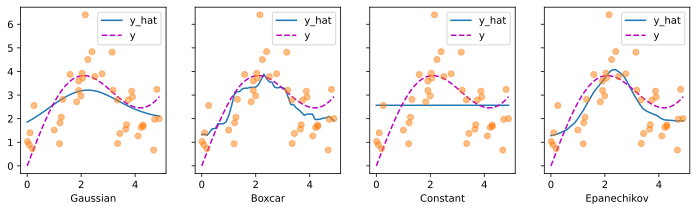

In [63]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

The first thing that stands out is that all three nontrivial kernels (Gaussian, Boxcar, and Epanechikov) produce fairly workable estimates that are not too far from the true function. Only the constant kernel that leads to the trivial estimate $f(x) = \frac{1}{n}\sum_i y_i$ produces a rather unrealistic result. Let’s inspect the attention weighting a bit more closely:

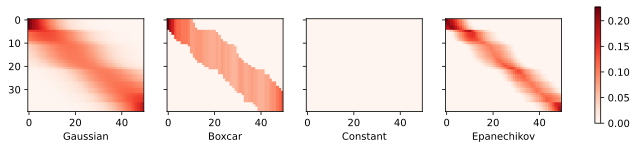

In [64]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The visualization clearly shows why the estimates for Gaussian, Boxcar, and Epanechikov are very similar: after all, they are derived from very similar attention weights, despite the different functional form of the kernel. 

We could replace the Gaussian kernel with one of a different width. That is, we could use $\alpha(q, k) = \text{exp}\left(-\frac{1}{2\sigma^2}\|q-k\|^2\right)$ where $\sigma^2$ determines the width of the kernel. Let’s see whether this affects the outcomes.

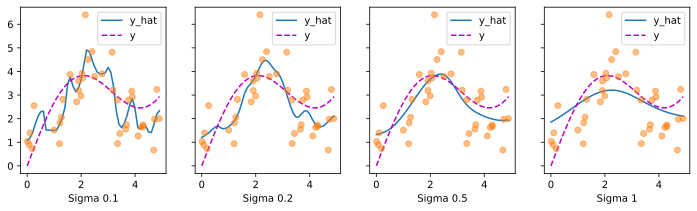

In [65]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

Clearly, the narrower the kernel, the less smooth the estimate. At the same time, it adapts better to the local variations. Let’s look at the corresponding attention weights.

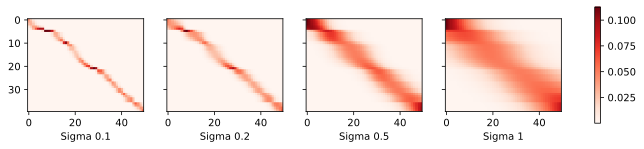

In [66]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

As we would expect, the narrower the kernel, the narrower the range of large attention weights. It is also clear that picking the same width might not be ideal.

Nadaraya–Watson kernel regression is an early precursor of the current attention mechanisms. It can be used directly with little to no training or tuning, either for classification or regression. The attention weight is assigned according to the similarity (or distance) between query and key, and according to how many similar observations are available. But it demonstrates the limits of hand-crafted attention mechanisms.

## Attention Scoring Functions
Attention scoring function $a(q, k_i) + \text{softmax} \rightarrow$ attention weights $\alpha(q, k_i)$.

$$\alpha(q, k_i) = \text{softmax}(a(q, k_i)) = \frac{\text{exp}(q^{\top}k_i/\sqrt{d})}{\sum_j \text{exp}(q^{\top}k_j/\sqrt{d})}$$

### Masked Softmax Operation
One of the most popular applications of the attention mechanism is to sequence models. Hence we need to be able to deal with sequences of different lengths. In some cases, such sequences may end up in the same minibatch, necessitating padding with dummy tokens for shorter sequences. These special tokens do not carry meaning. Since we do not want blanks in our attention model we simply need to limit $\sum_{i=1}^n\alpha(q, k_i)v_i$ to $\sum_{i=1}^l\alpha(q, k_i)v_i$ for however long, $l\le n$, the actual sentence is.

In [67]:
def masked_softmax(X, valid_lens): 
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Some examples:

In [68]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5597, 0.4403, 0.0000, 0.0000],
         [0.6536, 0.3464, 0.0000, 0.0000]],

        [[0.4178, 0.3296, 0.2526, 0.0000],
         [0.3102, 0.3536, 0.3361, 0.0000]]])

In [69]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2915, 0.3179, 0.3906, 0.0000]],

        [[0.6522, 0.3478, 0.0000, 0.0000],
         [0.1981, 0.2061, 0.3050, 0.2909]]])

### Scaled Dot Product Attention
$$\text{softmax}\left(\frac{QK^{\top}}{\sqrt{d}}\right)V \in R^{n\times v}$$

In [70]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens = None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

For example:

In [71]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval() # switch the model (or module) into evaluation mode
# during inference, dropout should be disabled
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

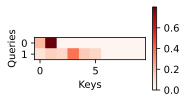

In [72]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### Additive Attention
When queries $q$ and keys $k$ are vectors of different dimension, we can either use a matrix to address the mismatch via $q^{\top}Mk$, or we can use additive attention as the scoring function. Given a query $q\in R^q$ and a key $k\in R^k$, the additive attention scoring function is given by
$$a(q, k) = w_v^{\top}\tanh(W_qq + W_kk)\in R$$
where $W_q\in R^{h\times q}, W_k\in R^{h\times k} and w_v\in R^h$ are the learnable parameters. This term is then fed into a softmax to ensure both nonnegativity and normalization. An equivalent interpretation is that the query and key are concatenated and fed into an MLP with a single hidden layer. Using $\tanh$ as the activation function and disabling bias terms

In [73]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries: (batch_size, num_queries, num_hiddens)\
keys: (batch_size, num_kv, num_hiddens)\
queries.unsqueeze(2): (batch_size, num_queries, 1, num_hiddens)\
keys.unsqueeze(1): (batch_size, 1, num_kv, num_hiddens)\
Adding: Broadcasting Happens:\
features: (batch_size, num_queries, num_kv, num_hiddens)\
scores: (batch_size, num_queries, num_kv)

For example:

In [74]:
queries = torch.normal(0, 1, (2, 1, 20))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

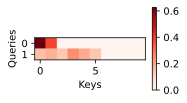

In [75]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## The Bahdanau Attention Mechanism
Conventionally, in an RNN all relevant information about a source sequence is translated into some internal fixed-dimensional state representation by the encoder. It is this very state that is used by the decoder as the complete and exclusive source of information for generating the translated sequence. In other words, the sequence-to-sequence mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

While this is quite reasonable for short sequences, it is clear that it is infeasible for long ones, such as a book chapter or even just a very long sentence. After all, before too long there will simply not be enough “space” in the intermediate representation to store all that is important in the source sequence. Consequently the decoder will fail to translate long and complex sentences.

Bahdanau et al. (2014) proposed a differentiable attention model without the unidirectional alignment limitation. When predicting a token, if not all the input tokens are relevant, the model attends only to parts of the input sequence that are deemed relevant to the current prediction. This is then used to update the current state before generating the next token. While quite innocuous in its description, this Bahdanau attention mechanism has arguably turned into one of the most influential ideas of the past decade in deep learning, giving rise to Transformers (Vaswani et al., 2017) and many related new architectures.

The key idea is that instead of keeping the state, i.e., the context variable $c$ summarizing the source sentence, as fixed, we dynamically update it, as a function of both the original text (encoder hidden states $h_t$) and the text that was already generated (decoder hidden states $s_{t'-1}$). This yields $c_{t'}$:
$$c_{t'} = \sum_{t=1}^T\alpha(s_{t'-1}, h_t)h_t$$

We used $s_{t'-1}$ as the query, and $h_t$ as both the key and the value. $c_{t'}$ is then used to generate the state $s_{t'}$ and to generate a new token. In particular, the attention weight $\alpha$ is computed using the additive attention scoring function.

To implement the RNN encoder–decoder with attention, we only need to redefine the decoder. Let’s begin with the base interface for decoders with attention by defining the quite unsurprisingly named AttentionDecoder class.

In [76]:
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    """useful when you want a consistent API across different attention-based decoders"""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError # must implement attention_weights in any subclass.

We need to implement the RNN decoder in the Seq2SeqAttentionDecoder class. The state of the decoder is initialized with (i) the hidden states of the last layer of the encoder at all time steps, used as keys and values for attention; (ii) the hidden state of the encoder at all layers at the final time step, which serves to initialize the hidden state of the decoder; and (iii) the valid length of the encoder, to exclude the padding tokens in attention pooling. At each decoding time step, the hidden state of the final layer of the decoder, obtained at the previous time step, is used as the query of the attention mechanism. Both the output of the attention mechanism and the input embedding are concatenated to serve as the input of the RNN decoder.

In [77]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        """initializes the decoder state using the encoder outputs"""
        # outputs: The full sequence of hidden states from the encoder (used for attention)
        # hidden_state: The encoder’s final hidden state (used to initialize the decoder)
        # enc_valid_lens: The actual lengths of the input sequences (for attention masking)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In the following, we test the implemented decoder with attention using a minibatch of four sequences, each of which are seven time steps long.

In [78]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

Now we can specify the hyperparameters, instantiate a regular encoder and a decoder with attention, and train this model for machine translation.

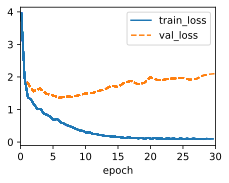

In [79]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr = 0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

After the model is trained, we use it to translate a few English sentences into French and compute their BLEU scores.

In [80]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'venu', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Let’s visualize the attention weights when translating the last English sentence. We see that each query assigns non-uniform weights over key–value pairs. It shows that at each decoding step, different parts of the input sequences are selectively aggregated in the attention pooling.

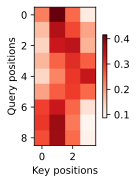

In [81]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## Multi-Head Attention

In practice, given the same set of queries, keys, and values we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (e.g., shorter-range vs. longer-range) within a sequence. Thus, it may be beneficial to allow our attention mechanism to jointly use different representation subspaces of queries, keys, and values.

To this end, instead of performing a single attention pooling, queries, keys, and values can be transformed with $h$ independently learned linear projections. Then these $h$ projected queries, keys, and values are fed into attention pooling in parallel. In the end, $h$ attention-pooling outputs are concatenated and transformed with another learned linear projection to produce the final output. This design is called multi-head attention, where each if the $h$ attention pooling outputs is a head.

In [82]:
class MultiHeadAttention(d2l.Module):
    """Multi-head attention"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 num_heads, dropout, bias = False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        output = self.attention(queries, keys, values, valid_lens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)
    
    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        X = X.permute(0, 2, 1, 3)
        return X.reshape(-1, X.shape[2], X.shape[3])
    
    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        """Concatenate the outputs from all heads"""
        """Return a unified representation for downstream layers"""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

Let’s test our implemented MultiHeadAttention class using a toy example where keys and values are the same. As a result, the shape of the multi-head attention output is (batch_size, num_queries, num_hiddens).

In [83]:
num_hiddens, num_heads = 100, 5
batch_size, num_queries, num_kvpairs = 2, 4, 6
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens), (batch_size, num_queries, num_hiddens))

## Self-Attention
Given a sequence of input tokens $x_1, ..., x_n$ where any $x_i\in R^d~(1\le i\le n)$, its self-attention outputs a sequence of the same length $y_1, ..., y_n$, where 
$$y_i = f(x_i, (x_1,x_1), ..., (x_n, x_n))\in R^d$$
according to the definition of attention pooling. Using multi-head attention, the following code snippet computes the self-attention of a tensor with shape (batch size, sequence length, d). The output tensor has the same shape.

In [84]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens), (batch_size, num_queries, num_hiddens))

## Positional Encoding
Unlike RNNs, which recurrently process tokens of a sequence one-by-one, self-attention ditches sequential operations in favor of parallel computation. Note that self-attention by itself does not preserve the order of the sequence. The dominant approach for preserving information about the order of tokens is to represent this to the model as an additional input associated with each token. These inputs are called positional encodings, and they can either be learned or fixed a priori. We now describe a simple scheme for fixed positional encodings based on sine and cosine functions.

Suppose that the input representation $X\in R^{n\times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. The positional encoding outputs $X+P$ using a positional embedding matrix $P\in R^{n\times d}$ of the same shape, whose element on the $i^{\text{th}}$ row and the $(2j)^{\text{th}}$ or the $(2j+1)^{\text{th}}$ column is 
$$p_{i,2j}=\sin\left(\frac{i}{10000^{2j/d}}\right)\\
p_{i,2j+1}=\cos\left(\frac{i}{10000^{2j/d}}\right)$$

In [85]:
class PositionalEncoding(d2l.Module):
    """Positional Encoding"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)/torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

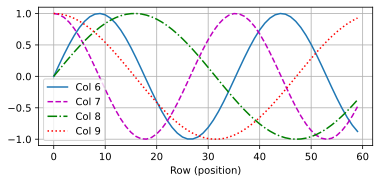

In [86]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

### Absolute Positional Information
The monotonically decreased frequency along the encoding dimension relates to absolute positional information. In binary representations, a higher bit has a lower frequency than a lower bit. Similarly, the positional encoding decreases frequencies along the encoding dimension by using trigonometric functions. Since the outputs are float numbers, such continuous representations are more space-efficient than binary representations.

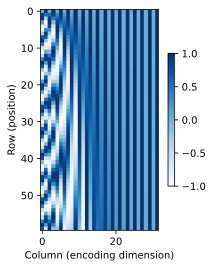

In [87]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0) # (1, 1, max_len, num_hiddens)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)', ylabel='Row (position)', 
                  figsize=(3.5, 4), cmap='Blues')

### Relative Positional Information
Besides capturing absolute positional information, the above positional encoding also allows a model to easily learn to attend by relative positions. This is because for any fixed position offset $\delta$, the positional encoding at position $i+\delta$ can be represented by a linear projection of that at position $i$.

This projection can be explained mathematically. Denoting $w_j=1/10000^{2j/d}$, any pair of $(p_{i,2j}, p_{i,2j+1})$ can be linearly projected to $(p_{i+\delta,2j}, p_{i+\delta,2j+1})$ for any fixed offset $\delta$:

$$\begin{bmatrix}
\cos(\delta \omega_j) & \sin(\delta \omega_j) \\
-\sin(\delta \omega_j) & \cos(\delta \omega_j)
\end{bmatrix}
\begin{bmatrix}
p_{i, 2j} \\
p_{i, 2j+1}
\end{bmatrix}
=
\begin{bmatrix}
\cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\
-\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j)
\end{bmatrix}\\
=
\begin{bmatrix}
\sin((i + \delta) \omega_j) \\
\cos((i + \delta) \omega_j)
\end{bmatrix}
=
\begin{bmatrix}
p_{i+\delta, 2j} \\
p_{i+\delta, 2j+1}
\end{bmatrix}$$

## The Transformer Architecture

The Transformer model is solely based on attention mechanisms without any convolutional or recurrent layer.

### Positionwise Feed-Forward Networks
The positionwise feed-forward network transforms the representation at all the sequence positions using the same MLP. In the implementation below, the input X with shape (batch size, sequence length in tokens, number of hidden units) will be transformed by a two-layer MLP into an output tensor of shape (batch size, number of time steps, ffn_num_outputs)

In [88]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

The following example shows that the innermost dimension of a tensor changes to the number of outputs in the positionwise feed-forward network. Since the same MLP transforms at all the positions, when the inputs at all these positions are the same, their outputs are also identical.

In [89]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.6834,  0.7323, -0.2642,  0.3217, -0.1930, -1.0660, -0.3290, -0.2261],
        [ 0.6834,  0.7323, -0.2642,  0.3217, -0.1930, -1.0660, -0.3290, -0.2261],
        [ 0.6834,  0.7323, -0.2642,  0.3217, -0.1930, -1.0660, -0.3290, -0.2261]],
       grad_fn=<SelectBackward0>)

### Residual Connection and Layer Normalization
Layer normalization is the same as batch normalization except that the former normalizes across the feature dimension, thus enjoying benefits of scale independence and batch size independence. Despite its pervasive applications in computer vision, batch normalization is usually empirically less effective than layer normalization in natural language processing tasks, where the inputs are often variable-length sequences.

The following code snippet compares the normalization across different dimensions by layer normalization and batch normalization.

In [90]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


Now we can implement the AddNorm class using a residual connection followed by layer normalization. Dropout is also applied for regularization.

In [91]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

The residual connection requires that the two inputs are of the same shape so that the output tensor also has the same shape after the addition operation.

In [92]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
d2l.check_shape(add_norm(torch.ones(shape), torch.ones(shape)), shape)

### Encoder
The following TransformerEncoderBlock class contains two sublayers: multi-head self-attention and positionwise feed-forward networks, where a residual connection followed by layer normalization is employed around both sublayers.

In [93]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, 
                                                num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

As we can see, no layer in the Transformer encoder changes the shape of its input.

In [94]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

In the following Transformer encoder implementation, we stack num_blks instances of the above TransformerEncoderBlock classes. Since we use the fixed positional encoding whose values are always between $-1$ and $1$, we multiply values of the learnable input embeddings by the square root of the embedding dimension to rescale before summing up the input embedding and the positional encoding.

In [95]:
class TransformerEncoder(d2l.Encoder):
    """The Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i), 
                                TransformerEncoderBlock(
                                    key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, 
                                    ffn_num_hiddens, num_heads, dropout, use_bias))
    
    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

Below we specify hyperparameters to create a two-layer Transformer encoder. The shape of the Transformer encoder output is (batch size, number of time steps, num_hiddens).

In [96]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
d2l.check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
                (2, 100, 24))

### Decoder
The Transformer decoder is composed of multiple identical layers. Each layer is implemented in the following TransformerDecoderBlock class, which contains three sublayers: decoder self-attention, encoder–decoder attention, and positionwise feed-forward networks. These sublayers employ a residual connection around them followed by layer normalization.

In the masked multi-head decoder self-attention (the first sublayer), queries, keys, and values all come from the outputs of the previous decoder layer. When training sequence-to-sequence models, tokens at all the positions (time steps) of the output sequence are known. However, during prediction the output sequence is generated token by token; thus, at any decoder time step only the generated tokens can be used in the decoder self-attention. To preserve autoregression in the decoder, its masked self-attention specifies dec_valid_lens so that any query only attends to all positions in the decoder up to the query position.

In [97]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, 
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                                 num_heads, dropout, bias = False)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                                 num_heads, dropout, bias = False)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim = 1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

To facilitate scaled dot product operations in the encoder–decoder attention and addition operations in the residual connections, the feature dimension (num_hiddens) of the decoder is the same as that of the encoder.

In [98]:
decoder_blk = TransformerDecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

Now we construct the entire Transformer decoder composed of num_blks instances of TransformerDecoderBlock. In the end, a fully connected layer computes the prediction for all the vocab_size possible output tokens. Both of the decoder self-attention weights and the encoder–decoder attention weights are stored for later visualization.

In [99]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape, 
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None]*self.num_blks]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

### Training
We train the Transformer model for sequence-to-sequence learning on the English–French machine translation dataset.

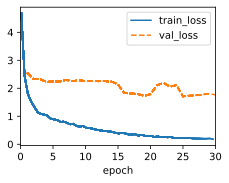

In [100]:
data = d2l.MTFraEng(batch_size=128)
key_size, query_size, value_size = 256, 256, 256
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_input, ffn_num_hiddens, num_heads = 256, 64, 4
norm_shape = [256]
encoder = TransformerEncoder(len(data.src_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             num_layers, dropout)
decoder = TransformerDecoder(len(data.tgt_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad = data.tgt_vocab['<pad>'], lr = 0.001)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

After training, we use the Transformer model to translate a few English sentences into French and compute their BLEU scores.

In [101]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', '<unk>', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Let’s visualize the Transformer attention weights when translating the final English sentence into French. The shape of the encoder self-attention weights is (number of encoder layers, number of attention heads, num_steps or number of queries, num_steps or number of key-value pairs).

In [102]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

In the encoder self-attention, both queries and keys come from the same input sequence. Since padding tokens do not carry meaning, with specified valid length of the input sequence no query attends to positions of padding tokens. In the following, two layers of multi-head attention weights are presented row by row. Each head independently attends based on a separate representation subspace of queries, keys, and values.

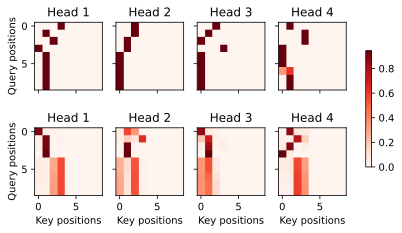

In [103]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

To visualize the decoder self-attention weights and the encoder–decoder attention weights, we need more data manipulations. For example, we fill the masked attention weights with zero. Note that the decoder self-attention weights and the encoder–decoder attention weights both have the same queries: the beginning-of-sequence token followed by the output tokens and possibly end-of-sequence tokens.

In [104]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

Because of the autoregressive property of the decoder self-attention, no query attends to key–value pairs after the query position.

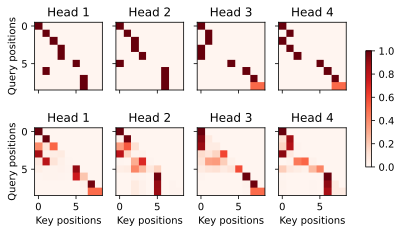

In [105]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

Similar to the case in the encoder self-attention, via the specified valid length of the input sequence, no query from the output sequence attends to those padding tokens from the input sequence.

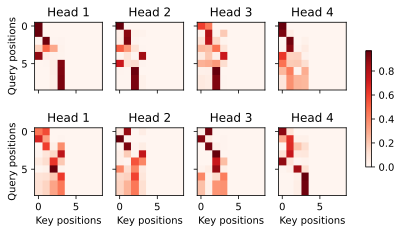

In [106]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))